In [22]:
import numpy as np
import pandas as pd
import os
from sklearn.cross_validation import cross_val_score as cv_score
from sklearn import cross_validation
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

Let's read input files

In [2]:
cwd = os.getcwd()
Train = pd.read_csv(os.path.join(cwd,'input/train.csv'))
Test = pd.read_csv(os.path.join(cwd,'input/test.csv'))

In [3]:
Train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [4]:
Test.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
Target = Train['target']
X_Train = Train.drop(['ID','target'],axis=1)
X_Test = Test.drop(['ID'],axis=1)

In [4]:
Constant_columns = [column for column in X_Train.columns if len(X_Train[column].unique())==1]
X_Train.drop(Constant_columns, axis = 1, inplace = True)
X_Test.drop(Constant_columns, axis = 1, inplace = True)
print 'Number of columns with constant value in Train:', len(Constant_columns)

Number of columns with constant value in Train: 256


In [7]:
pd.DataFrame({'Train data':[X_Train.shape[0],X_Train.shape[1],X_Train.isna().sum().sum()],
              'Test data':[X_Test.shape[0],X_Test.shape[1],X_Test.isna().sum().sum()]},
            index = ['Rows','Columns','Missing Values'])

,Test data,Train data
Rows,49342,4459
Columns,4735,4735
Missing Values,0,0


In [8]:
X_Train.describe()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,...,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.000000,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03
mean,1.465493e+04,1.390895e+03,2.672245e+04,4.530164e+03,2.640996e+04,3.070811e+04,1.686522e+04,4.669208e+03,2.569407e+06,1.552158e+05,...,4.676057e+05,4.446239e+05,8.056219e+05,7.812966e+05,143.529939,1.213809e+05,3.573451e+04,3.123741e+05,9.219960e+04,2.279100e+05
std,3.893298e+05,6.428302e+04,5.699652e+05,2.359124e+05,1.514730e+06,5.770590e+05,7.512756e+05,1.879449e+05,9.610183e+06,1.587815e+06,...,4.068038e+06,4.428889e+06,4.513246e+06,6.839451e+06,9584.318507,4.720709e+06,1.614622e+06,4.318501e+06,1.635993e+06,1.811139e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.000000e+07,4.000000e+06,2.000000e+07,1.480000e+07,1.000000e+08,2.070800e+07,4.000000e+07,1.040000e+07,3.196120e+08,6.000000e+07,...,7.600000e+07,1.235880e+08,1.300000e+08,1.444000e+08,640000.000000,3.013120e+08,1.064200e+08,1.400000e+08,6.176800e+07,4.320000e+07


In [9]:
X_Test.describe()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,...,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04
mean,5.773787e+04,6.258726e+04,1.036752e+05,6.289853e+04,6.713354e+04,8.083879e+04,6.181014e+04,5.515752e+04,1.406324e+06,8.128668e+04,...,1.193910e+05,1.355955e+05,3.242217e+05,1.437856e+05,9.302367e+04,8.047145e+04,6.076865e+04,1.323210e+05,1.675766e+05,1.282487e+05
std,1.745182e+06,2.322787e+06,2.586951e+06,2.765941e+06,3.206124e+06,2.845031e+06,2.780137e+06,1.923517e+06,6.872366e+06,2.378938e+06,...,3.115190e+06,2.598454e+06,3.782996e+06,3.663374e+06,5.041000e+06,2.100210e+06,2.040655e+06,3.592018e+06,3.761816e+06,2.413798e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.504447e+08,2.283295e+08,2.758171e+08,3.972621e+08,4.667591e+08,2.852223e+08,4.863751e+08,2.043290e+08,3.435658e+08,2.310167e+08,...,5.351692e+08,1.236547e+08,3.793398e+08,4.025480e+08,9.657530e+08,1.680065e+08,2.497913e+08,3.200000e+08,3.186300e+08,2.189782e+08


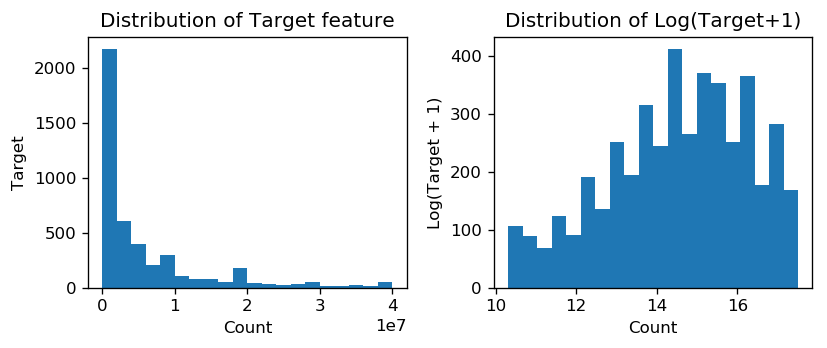

In [5]:
n_bins=20
Target_Log = pd.DataFrame({'Target_Log':np.log(Target.values+1)})

fig,axs = plt.subplots(1,2,figsize=(7, 3),dpi=120)

axs[0].hist(Target,bins=n_bins)
axs[1].hist(Target_Log.values,bins=n_bins)
axs[0].set_title('Distribution of Target feature')
axs[1].set_title('Distribution of Log(Target+1)')

axs[0].set_xlabel('Count')
axs[1].set_xlabel('Count')
axs[0].set_ylabel('Target')
axs[1].set_ylabel('Log(Target + 1)')
plt.tight_layout()
plt.show()

In [11]:
pd.concat([Target, Target_Log],axis=1).describe()

,target,Target_Log
count,4.459000e+03,4459.000000
mean,5.944923e+06,14.490239
std,8.234312e+06,1.750947
min,3.000000e+04,10.308986
25%,6.000000e+05,13.304687
50%,2.260000e+06,14.630876
75%,8.000000e+06,15.894952
max,4.000000e+07,17.504390


In [9]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X_Train.values, Target_Log.values, 
                                                                                     test_size = 0.3)
test_labels = test_labels.reshape(test_labels.shape[0],)

In [60]:
def LGBM_run(train_data, test_data, train_labels, test_labels, params):
    print'Start training...'
    # train
    gbm = lgb.LGBMRegressor(objective='regression',
                           num_leaves=params['num_leaves'],
                           learning_rate=params['learning_rate'],
                           n_estimators=params['n_estimators'],
                           random_state = 42)
    gbm.fit(train_data, train_labels,
            eval_set=[(test_data, test_labels)],
            eval_metric='rmse',
            early_stopping_rounds=100)
    print 'Start predicting...'
    # predict
    y_pred = gbm.predict(test_data, num_iteration=gbm.best_iteration_)
    # eval
    rmsel = mean_squared_error(test_labels, y_pred) ** 0.5
    print'The rmse of prediction is:', rmsel
    print 'Mean Relative Error:', rmsel/np.mean(test_labels)

    # feature importances
    feature_importances = list(gbm.feature_importances_)

    print 'Number of features with zero importance:', len([f for f in feature_importances if f==0])
    plt.title('Non-zero features importanse')
    plt.hist([f for f in feature_importances if f!=0],bins=100)
    plt.xlabel('Features importance')
    plt.ylabel('Counts')
    plt.show()
    
    return rmsel, feature_importances, gbm
   
def LGBM_optimisation(train_data, train_labels):    
    # other scikit-learn modules
    estimator = lgb.LGBMRegressor(num_leaves=31)

    param_grid = {
        'learning_rate': [0.01, 0.1, 1],
        'n_estimators': [20, 40, 60],
        'num_leaves': [5, 10, 15, 20, 25, 30]
    }
    
    gbm = GridSearchCV(estimator, param_grid)

    gbm.fit(train_data, train_labels)
    params = gbm.best_params_
    print'Best parameters found by grid search are:', params
    return params

Start training...
[1]	valid_0's rmse: 1.74555
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.74132
[3]	valid_0's rmse: 1.73733
[4]	valid_0's rmse: 1.73302
[5]	valid_0's rmse: 1.72906
[6]	valid_0's rmse: 1.72505
[7]	valid_0's rmse: 1.721
[8]	valid_0's rmse: 1.71696
[9]	valid_0's rmse: 1.71291
[10]	valid_0's rmse: 1.70903
Did not meet early stopping. Best iteration is:
[10]	valid_0's rmse: 1.70903
Start predicting...
The rmse of prediction is: 1.7090324937902903
Mean Relative Error: 0.11784637098979922
Number of features with zero importance: 75


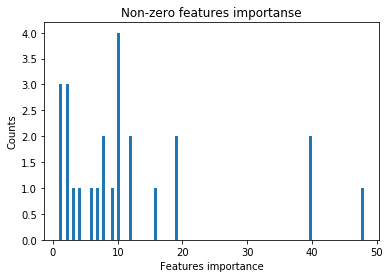

Best parameters found by grid search are: {'n_estimators': 40, 'num_leaves': 25, 'learning_rate': 0.1}
Start training...
[1]	valid_0's rmse: 1.70908
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67482
[3]	valid_0's rmse: 1.64582
[4]	valid_0's rmse: 1.61913
[5]	valid_0's rmse: 1.59597
[6]	valid_0's rmse: 1.58055
[7]	valid_0's rmse: 1.56341
[8]	valid_0's rmse: 1.55143
[9]	valid_0's rmse: 1.53663
[10]	valid_0's rmse: 1.52602
[11]	valid_0's rmse: 1.5148
[12]	valid_0's rmse: 1.50745
[13]	valid_0's rmse: 1.49989
[14]	valid_0's rmse: 1.49465
[15]	valid_0's rmse: 1.48824
[16]	valid_0's rmse: 1.48313
[17]	valid_0's rmse: 1.4766
[18]	valid_0's rmse: 1.47103
[19]	valid_0's rmse: 1.46719
[20]	valid_0's rmse: 1.46436
[21]	valid_0's rmse: 1.46149
[22]	valid_0's rmse: 1.4593
[23]	valid_0's rmse: 1.45828
[24]	valid_0's rmse: 1.45656
[25]	valid_0's rmse: 1.45342
[26]	valid_0's rmse: 1.45132
[27]	valid_0's rmse: 1.44971
[28]	valid_0's rmse: 1.44949
[29]	valid_0's r

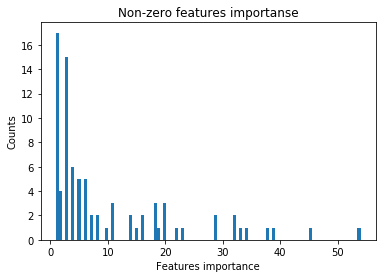

Start training...
[1]	valid_0's rmse: 1.7106
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67985
[3]	valid_0's rmse: 1.65149
[4]	valid_0's rmse: 1.62677
[5]	valid_0's rmse: 1.60149
[6]	valid_0's rmse: 1.58618
[7]	valid_0's rmse: 1.56443
[8]	valid_0's rmse: 1.55096
[9]	valid_0's rmse: 1.53823
[10]	valid_0's rmse: 1.53249
[11]	valid_0's rmse: 1.52116
[12]	valid_0's rmse: 1.51229
[13]	valid_0's rmse: 1.50277
[14]	valid_0's rmse: 1.49643
[15]	valid_0's rmse: 1.49174
[16]	valid_0's rmse: 1.48627
[17]	valid_0's rmse: 1.47897
[18]	valid_0's rmse: 1.47235
[19]	valid_0's rmse: 1.46866
[20]	valid_0's rmse: 1.46581
[21]	valid_0's rmse: 1.46211
[22]	valid_0's rmse: 1.46126
[23]	valid_0's rmse: 1.45872
[24]	valid_0's rmse: 1.45463
[25]	valid_0's rmse: 1.45364
[26]	valid_0's rmse: 1.45342
[27]	valid_0's rmse: 1.45119
[28]	valid_0's rmse: 1.45283
[29]	valid_0's rmse: 1.45331
[30]	valid_0's rmse: 1.45205
[31]	valid_0's rmse: 1.45274
[32]	valid_0's rmse: 1.45117
[

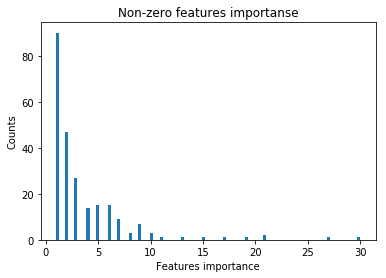

Best parameters found by grid search are: {'n_estimators': 40, 'num_leaves': 30, 'learning_rate': 0.1}
Start training...
[1]	valid_0's rmse: 1.70985
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67845
[3]	valid_0's rmse: 1.65137
[4]	valid_0's rmse: 1.62603
[5]	valid_0's rmse: 1.5996
[6]	valid_0's rmse: 1.58161
[7]	valid_0's rmse: 1.56663
[8]	valid_0's rmse: 1.55316
[9]	valid_0's rmse: 1.54021
[10]	valid_0's rmse: 1.53122
[11]	valid_0's rmse: 1.52118
[12]	valid_0's rmse: 1.51148
[13]	valid_0's rmse: 1.5066
[14]	valid_0's rmse: 1.4981
[15]	valid_0's rmse: 1.48806
[16]	valid_0's rmse: 1.48539
[17]	valid_0's rmse: 1.47978
[18]	valid_0's rmse: 1.47689
[19]	valid_0's rmse: 1.47004
[20]	valid_0's rmse: 1.46672
[21]	valid_0's rmse: 1.46348
[22]	valid_0's rmse: 1.45915
[23]	valid_0's rmse: 1.45827
[24]	valid_0's rmse: 1.45484
[25]	valid_0's rmse: 1.45241
[26]	valid_0's rmse: 1.44924
[27]	valid_0's rmse: 1.44715
[28]	valid_0's rmse: 1.44463
[29]	valid_0's r

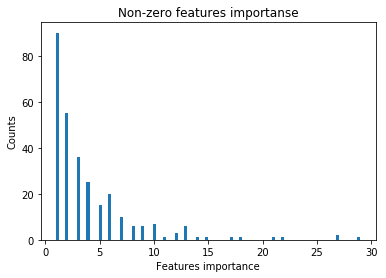

Start training...
[1]	valid_0's rmse: 1.70855
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67876
[3]	valid_0's rmse: 1.64713
[4]	valid_0's rmse: 1.62339
[5]	valid_0's rmse: 1.60281
[6]	valid_0's rmse: 1.58221
[7]	valid_0's rmse: 1.5603
[8]	valid_0's rmse: 1.54563
[9]	valid_0's rmse: 1.53327
[10]	valid_0's rmse: 1.52193
[11]	valid_0's rmse: 1.51143
[12]	valid_0's rmse: 1.50271
[13]	valid_0's rmse: 1.49427
[14]	valid_0's rmse: 1.48689
[15]	valid_0's rmse: 1.48135
[16]	valid_0's rmse: 1.47197
[17]	valid_0's rmse: 1.46785
[18]	valid_0's rmse: 1.46245
[19]	valid_0's rmse: 1.4583
[20]	valid_0's rmse: 1.45544
[21]	valid_0's rmse: 1.4534
[22]	valid_0's rmse: 1.44983
[23]	valid_0's rmse: 1.44654
[24]	valid_0's rmse: 1.44111
[25]	valid_0's rmse: 1.43786
[26]	valid_0's rmse: 1.43528
[27]	valid_0's rmse: 1.43284
[28]	valid_0's rmse: 1.43177
[29]	valid_0's rmse: 1.43018
[30]	valid_0's rmse: 1.43135
[31]	valid_0's rmse: 1.43195
[32]	valid_0's rmse: 1.43097
[33

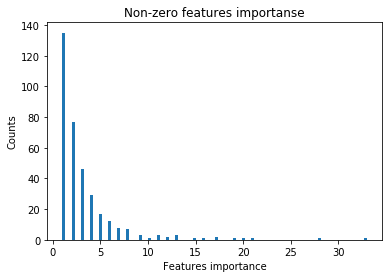

Best parameters found by grid search are: {'n_estimators': 40, 'num_leaves': 30, 'learning_rate': 0.1}
Start training...
[1]	valid_0's rmse: 1.70855
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67876
[3]	valid_0's rmse: 1.64713
[4]	valid_0's rmse: 1.62339
[5]	valid_0's rmse: 1.60281
[6]	valid_0's rmse: 1.58221
[7]	valid_0's rmse: 1.5603
[8]	valid_0's rmse: 1.54563
[9]	valid_0's rmse: 1.53327
[10]	valid_0's rmse: 1.52193
[11]	valid_0's rmse: 1.51143
[12]	valid_0's rmse: 1.50271
[13]	valid_0's rmse: 1.49427
[14]	valid_0's rmse: 1.48689
[15]	valid_0's rmse: 1.48135
[16]	valid_0's rmse: 1.47197
[17]	valid_0's rmse: 1.46785
[18]	valid_0's rmse: 1.46245
[19]	valid_0's rmse: 1.4583
[20]	valid_0's rmse: 1.45544
[21]	valid_0's rmse: 1.4534
[22]	valid_0's rmse: 1.44983
[23]	valid_0's rmse: 1.44654
[24]	valid_0's rmse: 1.44111
[25]	valid_0's rmse: 1.43786
[26]	valid_0's rmse: 1.43528
[27]	valid_0's rmse: 1.43284
[28]	valid_0's rmse: 1.43177
[29]	valid_0's r

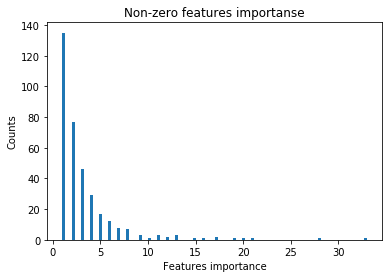

Start training...
[1]	valid_0's rmse: 1.70837
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67924
[3]	valid_0's rmse: 1.64704
[4]	valid_0's rmse: 1.62257
[5]	valid_0's rmse: 1.59675
[6]	valid_0's rmse: 1.5786
[7]	valid_0's rmse: 1.56321
[8]	valid_0's rmse: 1.55059
[9]	valid_0's rmse: 1.53779
[10]	valid_0's rmse: 1.52491
[11]	valid_0's rmse: 1.51737
[12]	valid_0's rmse: 1.50782
[13]	valid_0's rmse: 1.50099
[14]	valid_0's rmse: 1.49272
[15]	valid_0's rmse: 1.48613
[16]	valid_0's rmse: 1.4797
[17]	valid_0's rmse: 1.47502
[18]	valid_0's rmse: 1.47086
[19]	valid_0's rmse: 1.46769
[20]	valid_0's rmse: 1.4635
[21]	valid_0's rmse: 1.46015
[22]	valid_0's rmse: 1.45616
[23]	valid_0's rmse: 1.45313
[24]	valid_0's rmse: 1.45182
[25]	valid_0's rmse: 1.44943
[26]	valid_0's rmse: 1.44775
[27]	valid_0's rmse: 1.44583
[28]	valid_0's rmse: 1.44367
[29]	valid_0's rmse: 1.44171
[30]	valid_0's rmse: 1.43891
[31]	valid_0's rmse: 1.43783
[32]	valid_0's rmse: 1.43641
[33

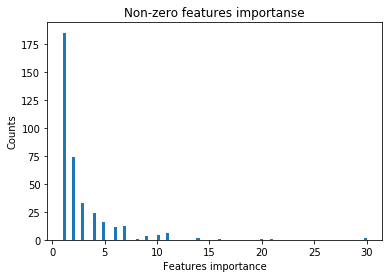

Best parameters found by grid search are: {'n_estimators': 40, 'num_leaves': 30, 'learning_rate': 0.1}
Start training...
[1]	valid_0's rmse: 1.70837
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67924
[3]	valid_0's rmse: 1.64704
[4]	valid_0's rmse: 1.62257
[5]	valid_0's rmse: 1.59675
[6]	valid_0's rmse: 1.5786
[7]	valid_0's rmse: 1.56321
[8]	valid_0's rmse: 1.55059
[9]	valid_0's rmse: 1.53779
[10]	valid_0's rmse: 1.52491
[11]	valid_0's rmse: 1.51737
[12]	valid_0's rmse: 1.50782
[13]	valid_0's rmse: 1.50099
[14]	valid_0's rmse: 1.49272
[15]	valid_0's rmse: 1.48613
[16]	valid_0's rmse: 1.4797
[17]	valid_0's rmse: 1.47502
[18]	valid_0's rmse: 1.47086
[19]	valid_0's rmse: 1.46769
[20]	valid_0's rmse: 1.4635
[21]	valid_0's rmse: 1.46015
[22]	valid_0's rmse: 1.45616
[23]	valid_0's rmse: 1.45313
[24]	valid_0's rmse: 1.45182
[25]	valid_0's rmse: 1.44943
[26]	valid_0's rmse: 1.44775
[27]	valid_0's rmse: 1.44583
[28]	valid_0's rmse: 1.44367
[29]	valid_0's r

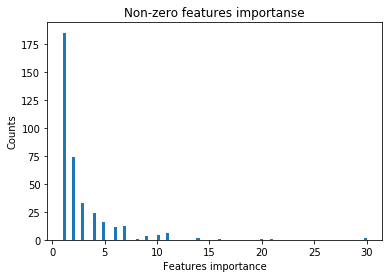

Start training...
[1]	valid_0's rmse: 1.70837
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67924
[3]	valid_0's rmse: 1.64704
[4]	valid_0's rmse: 1.62258
[5]	valid_0's rmse: 1.59705
[6]	valid_0's rmse: 1.58015
[7]	valid_0's rmse: 1.56378
[8]	valid_0's rmse: 1.54872
[9]	valid_0's rmse: 1.53573
[10]	valid_0's rmse: 1.52494
[11]	valid_0's rmse: 1.51189
[12]	valid_0's rmse: 1.50361
[13]	valid_0's rmse: 1.49426
[14]	valid_0's rmse: 1.48776
[15]	valid_0's rmse: 1.47989
[16]	valid_0's rmse: 1.47371
[17]	valid_0's rmse: 1.46792
[18]	valid_0's rmse: 1.46283
[19]	valid_0's rmse: 1.45832
[20]	valid_0's rmse: 1.45452
[21]	valid_0's rmse: 1.44971
[22]	valid_0's rmse: 1.44772
[23]	valid_0's rmse: 1.44509
[24]	valid_0's rmse: 1.44317
[25]	valid_0's rmse: 1.44055
[26]	valid_0's rmse: 1.43956
[27]	valid_0's rmse: 1.43866
[28]	valid_0's rmse: 1.43721
[29]	valid_0's rmse: 1.43602
[30]	valid_0's rmse: 1.43537
[31]	valid_0's rmse: 1.43572
[32]	valid_0's rmse: 1.43322


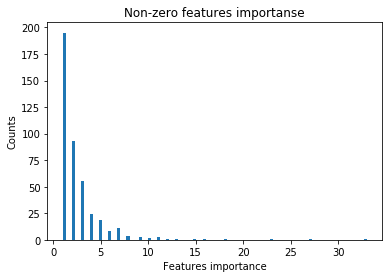

Best parameters found by grid search are: {'n_estimators': 40, 'num_leaves': 30, 'learning_rate': 0.1}
Start training...
[1]	valid_0's rmse: 1.70837
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67924
[3]	valid_0's rmse: 1.64704
[4]	valid_0's rmse: 1.62258
[5]	valid_0's rmse: 1.59705
[6]	valid_0's rmse: 1.58015
[7]	valid_0's rmse: 1.56378
[8]	valid_0's rmse: 1.54872
[9]	valid_0's rmse: 1.53573
[10]	valid_0's rmse: 1.52494
[11]	valid_0's rmse: 1.51189
[12]	valid_0's rmse: 1.50361
[13]	valid_0's rmse: 1.49426
[14]	valid_0's rmse: 1.48776
[15]	valid_0's rmse: 1.47989
[16]	valid_0's rmse: 1.47371
[17]	valid_0's rmse: 1.46792
[18]	valid_0's rmse: 1.46283
[19]	valid_0's rmse: 1.45832
[20]	valid_0's rmse: 1.45452
[21]	valid_0's rmse: 1.44971
[22]	valid_0's rmse: 1.44772
[23]	valid_0's rmse: 1.44509
[24]	valid_0's rmse: 1.44317
[25]	valid_0's rmse: 1.44055
[26]	valid_0's rmse: 1.43956
[27]	valid_0's rmse: 1.43866
[28]	valid_0's rmse: 1.43721
[29]	valid_0'

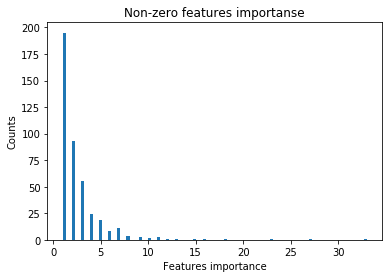

Start training...
[1]	valid_0's rmse: 1.70966
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67887
[3]	valid_0's rmse: 1.65065
[4]	valid_0's rmse: 1.62482
[5]	valid_0's rmse: 1.60076
[6]	valid_0's rmse: 1.58267
[7]	valid_0's rmse: 1.56698
[8]	valid_0's rmse: 1.5528
[9]	valid_0's rmse: 1.53716
[10]	valid_0's rmse: 1.52528
[11]	valid_0's rmse: 1.51203
[12]	valid_0's rmse: 1.50262
[13]	valid_0's rmse: 1.492
[14]	valid_0's rmse: 1.48639
[15]	valid_0's rmse: 1.48024
[16]	valid_0's rmse: 1.47662
[17]	valid_0's rmse: 1.47103
[18]	valid_0's rmse: 1.46615
[19]	valid_0's rmse: 1.46234
[20]	valid_0's rmse: 1.4596
[21]	valid_0's rmse: 1.45597
[22]	valid_0's rmse: 1.45374
[23]	valid_0's rmse: 1.45211
[24]	valid_0's rmse: 1.44925
[25]	valid_0's rmse: 1.4473
[26]	valid_0's rmse: 1.44593
[27]	valid_0's rmse: 1.4446
[28]	valid_0's rmse: 1.44354
[29]	valid_0's rmse: 1.44209
[30]	valid_0's rmse: 1.44311
[31]	valid_0's rmse: 1.44241
[32]	valid_0's rmse: 1.44183
[33]	v

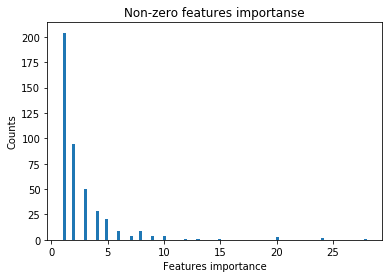

Best parameters found by grid search are: {'n_estimators': 40, 'num_leaves': 30, 'learning_rate': 0.1}
Start training...
[1]	valid_0's rmse: 1.70966
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67887
[3]	valid_0's rmse: 1.65065
[4]	valid_0's rmse: 1.62482
[5]	valid_0's rmse: 1.60076
[6]	valid_0's rmse: 1.58267
[7]	valid_0's rmse: 1.56698
[8]	valid_0's rmse: 1.5528
[9]	valid_0's rmse: 1.53716
[10]	valid_0's rmse: 1.52528
[11]	valid_0's rmse: 1.51203
[12]	valid_0's rmse: 1.50262
[13]	valid_0's rmse: 1.492
[14]	valid_0's rmse: 1.48639
[15]	valid_0's rmse: 1.48024
[16]	valid_0's rmse: 1.47662
[17]	valid_0's rmse: 1.47103
[18]	valid_0's rmse: 1.46615
[19]	valid_0's rmse: 1.46234
[20]	valid_0's rmse: 1.4596
[21]	valid_0's rmse: 1.45597
[22]	valid_0's rmse: 1.45374
[23]	valid_0's rmse: 1.45211
[24]	valid_0's rmse: 1.44925
[25]	valid_0's rmse: 1.4473
[26]	valid_0's rmse: 1.44593
[27]	valid_0's rmse: 1.4446
[28]	valid_0's rmse: 1.44354
[29]	valid_0's rmse

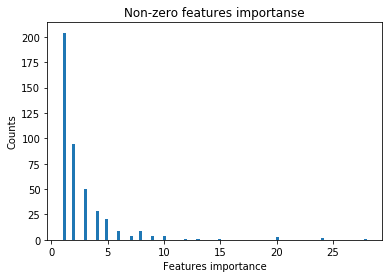

Start training...
[1]	valid_0's rmse: 1.70966
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67887
[3]	valid_0's rmse: 1.64916
[4]	valid_0's rmse: 1.62543
[5]	valid_0's rmse: 1.59864
[6]	valid_0's rmse: 1.58021
[7]	valid_0's rmse: 1.5587
[8]	valid_0's rmse: 1.54387
[9]	valid_0's rmse: 1.53077
[10]	valid_0's rmse: 1.51909
[11]	valid_0's rmse: 1.5104
[12]	valid_0's rmse: 1.50112
[13]	valid_0's rmse: 1.49419
[14]	valid_0's rmse: 1.48742
[15]	valid_0's rmse: 1.47923
[16]	valid_0's rmse: 1.4735
[17]	valid_0's rmse: 1.47134
[18]	valid_0's rmse: 1.46838
[19]	valid_0's rmse: 1.46417
[20]	valid_0's rmse: 1.45575
[21]	valid_0's rmse: 1.45064
[22]	valid_0's rmse: 1.44945
[23]	valid_0's rmse: 1.44624
[24]	valid_0's rmse: 1.44256
[25]	valid_0's rmse: 1.44101
[26]	valid_0's rmse: 1.43946
[27]	valid_0's rmse: 1.43689
[28]	valid_0's rmse: 1.43615
[29]	valid_0's rmse: 1.43569
[30]	valid_0's rmse: 1.43511
[31]	valid_0's rmse: 1.43303
[32]	valid_0's rmse: 1.4323
[33]

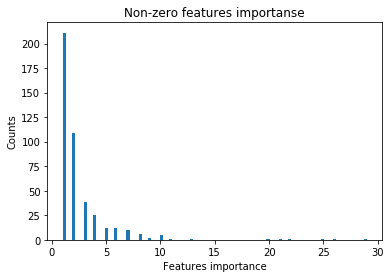

Best parameters found by grid search are: {'n_estimators': 40, 'num_leaves': 25, 'learning_rate': 0.1}
Start training...
[1]	valid_0's rmse: 1.7101
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67942
[3]	valid_0's rmse: 1.65457
[4]	valid_0's rmse: 1.62682
[5]	valid_0's rmse: 1.60656
[6]	valid_0's rmse: 1.58497
[7]	valid_0's rmse: 1.57013
[8]	valid_0's rmse: 1.55646
[9]	valid_0's rmse: 1.54536
[10]	valid_0's rmse: 1.53257
[11]	valid_0's rmse: 1.52118
[12]	valid_0's rmse: 1.5125
[13]	valid_0's rmse: 1.50307
[14]	valid_0's rmse: 1.49589
[15]	valid_0's rmse: 1.49001
[16]	valid_0's rmse: 1.48392
[17]	valid_0's rmse: 1.47634
[18]	valid_0's rmse: 1.47083
[19]	valid_0's rmse: 1.46674
[20]	valid_0's rmse: 1.46435
[21]	valid_0's rmse: 1.46104
[22]	valid_0's rmse: 1.45771
[23]	valid_0's rmse: 1.45355
[24]	valid_0's rmse: 1.45205
[25]	valid_0's rmse: 1.44816
[26]	valid_0's rmse: 1.44639
[27]	valid_0's rmse: 1.4443
[28]	valid_0's rmse: 1.44261
[29]	valid_0's r

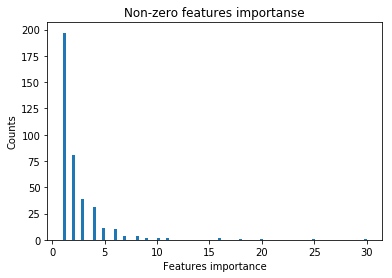

Start training...
[1]	valid_0's rmse: 1.7101
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.68201
[3]	valid_0's rmse: 1.65136
[4]	valid_0's rmse: 1.62801
[5]	valid_0's rmse: 1.60546
[6]	valid_0's rmse: 1.58932
[7]	valid_0's rmse: 1.57585
[8]	valid_0's rmse: 1.56206
[9]	valid_0's rmse: 1.54561
[10]	valid_0's rmse: 1.53553
[11]	valid_0's rmse: 1.52476
[12]	valid_0's rmse: 1.5164
[13]	valid_0's rmse: 1.50714
[14]	valid_0's rmse: 1.49939
[15]	valid_0's rmse: 1.49238
[16]	valid_0's rmse: 1.4894
[17]	valid_0's rmse: 1.48448
[18]	valid_0's rmse: 1.4806
[19]	valid_0's rmse: 1.47671
[20]	valid_0's rmse: 1.47226
[21]	valid_0's rmse: 1.46953
[22]	valid_0's rmse: 1.46609
[23]	valid_0's rmse: 1.46394
[24]	valid_0's rmse: 1.46214
[25]	valid_0's rmse: 1.45943
[26]	valid_0's rmse: 1.45777
[27]	valid_0's rmse: 1.4554
[28]	valid_0's rmse: 1.45446
[29]	valid_0's rmse: 1.45567
[30]	valid_0's rmse: 1.45514
[31]	valid_0's rmse: 1.45378
[32]	valid_0's rmse: 1.45298
[33]	

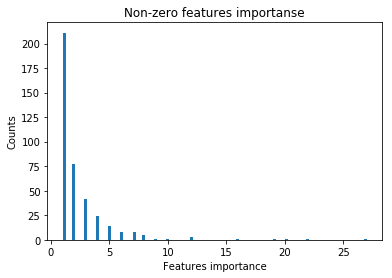

Best parameters found by grid search are: {'n_estimators': 40, 'num_leaves': 30, 'learning_rate': 0.1}
Start training...
[1]	valid_0's rmse: 1.70966
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67887
[3]	valid_0's rmse: 1.64916
[4]	valid_0's rmse: 1.62439
[5]	valid_0's rmse: 1.59755
[6]	valid_0's rmse: 1.57787
[7]	valid_0's rmse: 1.55974
[8]	valid_0's rmse: 1.54656
[9]	valid_0's rmse: 1.53355
[10]	valid_0's rmse: 1.52286
[11]	valid_0's rmse: 1.51309
[12]	valid_0's rmse: 1.50313
[13]	valid_0's rmse: 1.49554
[14]	valid_0's rmse: 1.48851
[15]	valid_0's rmse: 1.48014
[16]	valid_0's rmse: 1.47555
[17]	valid_0's rmse: 1.46877
[18]	valid_0's rmse: 1.46473
[19]	valid_0's rmse: 1.46053
[20]	valid_0's rmse: 1.45677
[21]	valid_0's rmse: 1.45367
[22]	valid_0's rmse: 1.45133
[23]	valid_0's rmse: 1.44783
[24]	valid_0's rmse: 1.44404
[25]	valid_0's rmse: 1.44343
[26]	valid_0's rmse: 1.44296
[27]	valid_0's rmse: 1.44153
[28]	valid_0's rmse: 1.44027
[29]	valid_0'

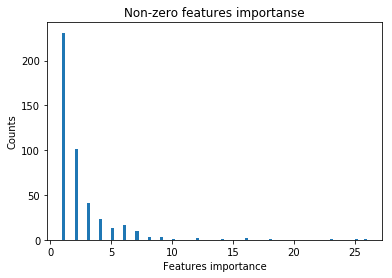

Start training...
[1]	valid_0's rmse: 1.70966
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67887
[3]	valid_0's rmse: 1.64916
[4]	valid_0's rmse: 1.62461
[5]	valid_0's rmse: 1.59777
[6]	valid_0's rmse: 1.578
[7]	valid_0's rmse: 1.55986
[8]	valid_0's rmse: 1.54555
[9]	valid_0's rmse: 1.53587
[10]	valid_0's rmse: 1.52173
[11]	valid_0's rmse: 1.51439
[12]	valid_0's rmse: 1.50607
[13]	valid_0's rmse: 1.49873
[14]	valid_0's rmse: 1.49314
[15]	valid_0's rmse: 1.48646
[16]	valid_0's rmse: 1.47899
[17]	valid_0's rmse: 1.47328
[18]	valid_0's rmse: 1.46471
[19]	valid_0's rmse: 1.46138
[20]	valid_0's rmse: 1.45819
[21]	valid_0's rmse: 1.45452
[22]	valid_0's rmse: 1.45116
[23]	valid_0's rmse: 1.44818
[24]	valid_0's rmse: 1.44655
[25]	valid_0's rmse: 1.44385
[26]	valid_0's rmse: 1.44252
[27]	valid_0's rmse: 1.44131
[28]	valid_0's rmse: 1.44017
[29]	valid_0's rmse: 1.43996
[30]	valid_0's rmse: 1.43913
[31]	valid_0's rmse: 1.43961
[32]	valid_0's rmse: 1.43787
[3

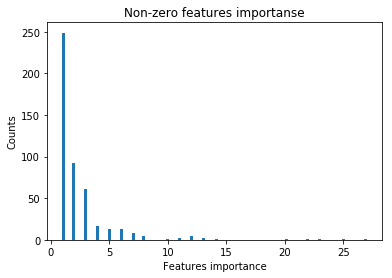

Best parameters found by grid search are: {'n_estimators': 40, 'num_leaves': 30, 'learning_rate': 0.1}
Start training...
[1]	valid_0's rmse: 1.70966
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67887
[3]	valid_0's rmse: 1.64916
[4]	valid_0's rmse: 1.62461
[5]	valid_0's rmse: 1.59777
[6]	valid_0's rmse: 1.578
[7]	valid_0's rmse: 1.55986
[8]	valid_0's rmse: 1.54555
[9]	valid_0's rmse: 1.53587
[10]	valid_0's rmse: 1.52173
[11]	valid_0's rmse: 1.51439
[12]	valid_0's rmse: 1.50607
[13]	valid_0's rmse: 1.49873
[14]	valid_0's rmse: 1.49314
[15]	valid_0's rmse: 1.48646
[16]	valid_0's rmse: 1.47899
[17]	valid_0's rmse: 1.47328
[18]	valid_0's rmse: 1.46471
[19]	valid_0's rmse: 1.46138
[20]	valid_0's rmse: 1.45819
[21]	valid_0's rmse: 1.45452
[22]	valid_0's rmse: 1.45116
[23]	valid_0's rmse: 1.44818
[24]	valid_0's rmse: 1.44655
[25]	valid_0's rmse: 1.44385
[26]	valid_0's rmse: 1.44252
[27]	valid_0's rmse: 1.44131
[28]	valid_0's rmse: 1.44017
[29]	valid_0's 

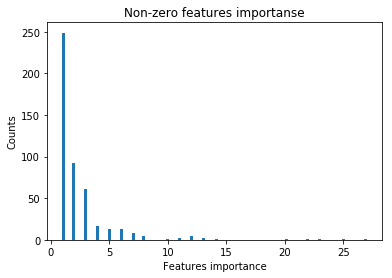

Start training...
[1]	valid_0's rmse: 1.70966
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67936
[3]	valid_0's rmse: 1.64863
[4]	valid_0's rmse: 1.62607
[5]	valid_0's rmse: 1.60059
[6]	valid_0's rmse: 1.58309
[7]	valid_0's rmse: 1.56943
[8]	valid_0's rmse: 1.55542
[9]	valid_0's rmse: 1.54156
[10]	valid_0's rmse: 1.52749
[11]	valid_0's rmse: 1.51831
[12]	valid_0's rmse: 1.51167
[13]	valid_0's rmse: 1.50417
[14]	valid_0's rmse: 1.49617
[15]	valid_0's rmse: 1.48793
[16]	valid_0's rmse: 1.48416
[17]	valid_0's rmse: 1.48083
[18]	valid_0's rmse: 1.47692
[19]	valid_0's rmse: 1.47333
[20]	valid_0's rmse: 1.46932
[21]	valid_0's rmse: 1.46421
[22]	valid_0's rmse: 1.46134
[23]	valid_0's rmse: 1.45904
[24]	valid_0's rmse: 1.45611
[25]	valid_0's rmse: 1.45307
[26]	valid_0's rmse: 1.45159
[27]	valid_0's rmse: 1.45132
[28]	valid_0's rmse: 1.45031
[29]	valid_0's rmse: 1.45149
[30]	valid_0's rmse: 1.45001
[31]	valid_0's rmse: 1.45028
[32]	valid_0's rmse: 1.45028


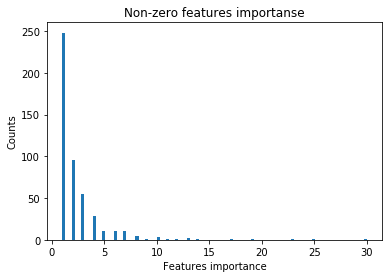

Best parameters found by grid search are: {'n_estimators': 40, 'num_leaves': 30, 'learning_rate': 0.1}
Start training...
[1]	valid_0's rmse: 1.70966
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.67936
[3]	valid_0's rmse: 1.64863
[4]	valid_0's rmse: 1.62607
[5]	valid_0's rmse: 1.60059
[6]	valid_0's rmse: 1.58309
[7]	valid_0's rmse: 1.56943
[8]	valid_0's rmse: 1.55542
[9]	valid_0's rmse: 1.54156
[10]	valid_0's rmse: 1.52749
[11]	valid_0's rmse: 1.51831
[12]	valid_0's rmse: 1.51167
[13]	valid_0's rmse: 1.50417
[14]	valid_0's rmse: 1.49617
[15]	valid_0's rmse: 1.48793
[16]	valid_0's rmse: 1.48416
[17]	valid_0's rmse: 1.48083
[18]	valid_0's rmse: 1.47692
[19]	valid_0's rmse: 1.47333
[20]	valid_0's rmse: 1.46932
[21]	valid_0's rmse: 1.46421
[22]	valid_0's rmse: 1.46134
[23]	valid_0's rmse: 1.45904
[24]	valid_0's rmse: 1.45611
[25]	valid_0's rmse: 1.45307
[26]	valid_0's rmse: 1.45159
[27]	valid_0's rmse: 1.45132
[28]	valid_0's rmse: 1.45031
[29]	valid_0'

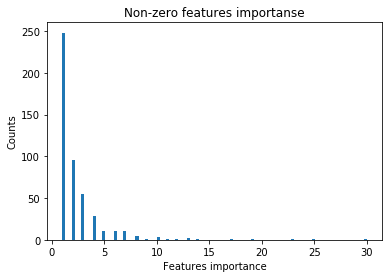

In [61]:
rmsels_baisic=[]
rmsels_optimized=[]
params = {'learning_rate': 0.01,
        'n_estimators': 10,
        'num_leaves': 31}
for k in range(100,4735,500):
    select_feature = SelectKBest(f_regression, k=k).fit(train_data,train_labels)

    train_data_transformed = list(select_feature.transform(train_data))
    test_data_transformed = list(select_feature.transform(test_data))
    
    rmsel, feature_importances, gbm = LGBM_run(train_data_transformed, test_data_transformed, list(train_labels), list(test_labels), params)
    rmsels_baisic.append(rmsel)
    
    params = LGBM_optimisation(train_data_transformed, train_labels)
    
    rmsel, feature_importances, gbm = LGBM_run(train_data_transformed, test_data_transformed, list(train_labels), list(test_labels), params)
    rmsels_optimized.append(rmsel)

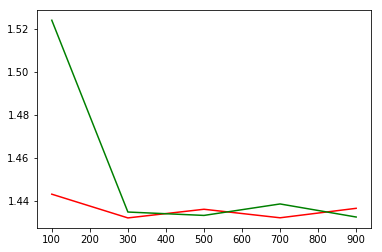

In [33]:
rmsels_baisic100_1100=rmsels_baisic
rmsels_optimized100_1100=rmsels_optimized
plt.plot(range(100,1100,200),rmsels_optimized100_1100,'r',range(100,1100,200),rmsels_baisic100_1100,'g')

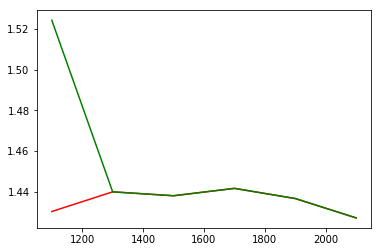

In [37]:
rmsels_baisic1100_2200=rmsels_baisic
rmsels_optimized1100_2200=rmsels_optimized
plt.plot(range(1100,2200,200),rmsels_optimized1100_2200,'r',range(1100,2200,200),rmsels_baisic1100_2200,'g')

{'learning_rate': 0.1, 'n_estimators': 40, 'num_leaves': 30}

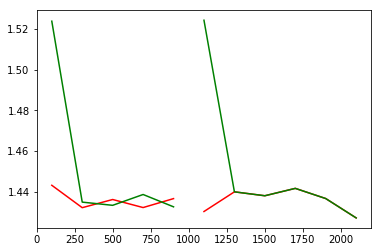

In [39]:
plt.plot(range(1100,2200,200),rmsels_optimized1100_2200,'r',range(1100,2200,200),rmsels_baisic1100_2200,'g')
plt.plot(range(100,1100,200),rmsels_optimized100_1100,'r',range(100,1100,200),rmsels_baisic100_1100,'g')
params

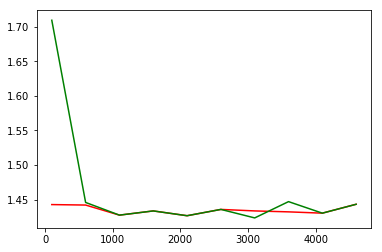

In [62]:
plt.plot(range(100,4735,500),rmsels_optimized,'r',range(100,4735,500),rmsels_baisic,'g')

In [14]:
columns_to_drop=[]
for count,feature_importance in enumerate(feature_importances):
    if feature_importance==0:
        columns_to_drop.append(X_Train.columns[count])

X_Train_reduced = X_Train.drop(columns_to_drop,axis=1)
X_Test_reduced = X_Test.drop(columns_to_drop,axis=1)

train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X_Train_reduced.values, Target_Log.values, 
                                                                                     test_size = 0.3)
test_labels = test_labels.reshape(test_labels.shape[0],)

Start training...
[1]	valid_0's rmse: 1.74745
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 1.71432
[3]	valid_0's rmse: 1.6877
[4]	valid_0's rmse: 1.66942
[5]	valid_0's rmse: 1.65138
[6]	valid_0's rmse: 1.63868
[7]	valid_0's rmse: 1.62859
[8]	valid_0's rmse: 1.619
[9]	valid_0's rmse: 1.61013
[10]	valid_0's rmse: 1.60422
[11]	valid_0's rmse: 1.59528
[12]	valid_0's rmse: 1.58839
[13]	valid_0's rmse: 1.5826
[14]	valid_0's rmse: 1.57827
[15]	valid_0's rmse: 1.57569
[16]	valid_0's rmse: 1.57263
[17]	valid_0's rmse: 1.5712
[18]	valid_0's rmse: 1.56684
[19]	valid_0's rmse: 1.56328
[20]	valid_0's rmse: 1.55963
[21]	valid_0's rmse: 1.55735
[22]	valid_0's rmse: 1.55634
[23]	valid_0's rmse: 1.55399
[24]	valid_0's rmse: 1.5516
[25]	valid_0's rmse: 1.55168
[26]	valid_0's rmse: 1.55027
[27]	valid_0's rmse: 1.55082
[28]	valid_0's rmse: 1.54903
[29]	valid_0's rmse: 1.54841
[30]	valid_0's rmse: 1.54804
[31]	valid_0's rmse: 1.54746
[32]	valid_0's rmse: 1.54751
[33]	val

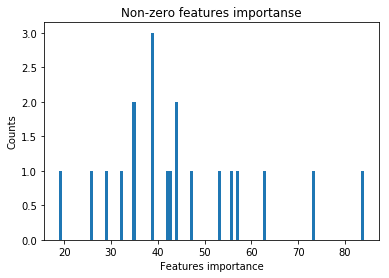

In [42]:
print'Start training...'
# train
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=best_params['num_leaves'],
                        learning_rate=best_params['learning_rate'],
                        n_estimators=best_params['n_estimators'],
                       random_state = 42)
gbm.fit(train_data, train_labels,
        eval_set=[(test_data, test_labels)],
        eval_metric='rmse',
        early_stopping_rounds=5)

print 'Start predicting...'
# predict
y_pred = gbm.predict(test_data, num_iteration=gbm.best_iteration_)
# eval
print'The rmse of prediction is:', mean_squared_error(test_labels, y_pred) ** 0.5
print 'Mean Relative Error:', mean_squared_error(test_labels, y_pred) ** 0.5/np.mean(test_labels)
# feature importances
print'Feature importances:'
feature_importances = list(gbm.feature_importances_)

print 'Number of features with zero importance:', len([f for f in feature_importances if f==0])
plt.title('Non-zero features importanse')
plt.hist([f for f in feature_importances if f!=0],bins=100)
plt.xlabel('Features importance')
plt.ylabel('Counts')
plt.show()


In [28]:
for count,feature_importance in enumerate(feature_importances):
    if feature_importance==0:
        columns_to_drop.append(X_Train.columns[count])

X_Train_reduced = X_Train.drop(columns_to_drop,axis=1)
X_Test_reduced = X_Test.drop(columns_to_drop,axis=1)

train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X_Train_reduced.values, Target_Log.values, 
                                                                                     test_size = 0.3)
test_labels = test_labels.reshape(test_labels.shape[0],)
train_data.shape

(3121, 180)

Start training...
[1]	valid_0's l1: 1.3928
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 1.36908
[3]	valid_0's l1: 1.34699
[4]	valid_0's l1: 1.32654
[5]	valid_0's l1: 1.30544
[6]	valid_0's l1: 1.28599
[7]	valid_0's l1: 1.26858
[8]	valid_0's l1: 1.25271
[9]	valid_0's l1: 1.23981
[10]	valid_0's l1: 1.22579
[11]	valid_0's l1: 1.21456
[12]	valid_0's l1: 1.20443
[13]	valid_0's l1: 1.19383
[14]	valid_0's l1: 1.18655
[15]	valid_0's l1: 1.17777
[16]	valid_0's l1: 1.16965
[17]	valid_0's l1: 1.16405
[18]	valid_0's l1: 1.15963
[19]	valid_0's l1: 1.15355
[20]	valid_0's l1: 1.15034
[21]	valid_0's l1: 1.14516
[22]	valid_0's l1: 1.14046
[23]	valid_0's l1: 1.13817
[24]	valid_0's l1: 1.13512
[25]	valid_0's l1: 1.13237
[26]	valid_0's l1: 1.12966
[27]	valid_0's l1: 1.12681
[28]	valid_0's l1: 1.12447
[29]	valid_0's l1: 1.12328
[30]	valid_0's l1: 1.12115
[31]	valid_0's l1: 1.11867
[32]	valid_0's l1: 1.11744
[33]	valid_0's l1: 1.11756
[34]	valid_0's l1: 1.117
[35]	valid_0's 

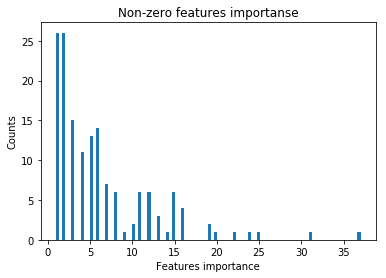

In [27]:
print'Start training...'
# train
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=best_params['num_leaves'],
                        learning_rate=best_params['learning_rate'],
                        n_estimators=best_params['n_estimators'],
                       random_state = 42)
gbm.fit(train_data, train_labels,
        eval_set=[(test_data, test_labels)],
        eval_metric='l1',
        early_stopping_rounds=5)

print 'Start predicting...'
# predict
y_pred = gbm.predict(test_data, num_iteration=gbm.best_iteration_)
# eval
print'The rmse of prediction is:', mean_squared_error(test_labels, y_pred) ** 0.5
print 'Mean Relative Error:', mean_squared_error(test_labels, y_pred) ** 0.5/np.mean(test_labels)
# feature importances
print'Feature importances:'
feature_importances = list(gbm.feature_importances_)

print 'Number of features with zero importance:', len([f for f in feature_importances if f==0])
plt.title('Non-zero features importanse')
plt.hist([f for f in feature_importances if f!=0],bins=100)
plt.xlabel('Features importance')
plt.ylabel('Counts')
plt.show()

In [47]:
0.10031513314961377

0.10031513314961377